In [118]:
import pandas as pd
import category_encoders as ce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA,TruncatedSVD #主成分分析ライブラリ

In [38]:
csv_file = '学歴フィルターが学生の企業や社員へのイメージに与える影響（回答） - フォームの回答 1.csv'

In [91]:
normal_dic = {
    'とてもそう思う' : 5,
    'そう思う' : 4,
    'どちらともいえない' : 3,
    'そう思わない' : 2,
    '全くそう思わない' : 1
}

reverse_dic = {
    'とてもそう思う' : 1,
    'そう思う' : 2,
    'どちらともいえない' : 3,
    'そう思わない' : 4,
    '全くそう思わない' : 5
}

#   '自身の待遇についてどう感じましたか。'
other_dic1 = {
    '非常に優遇されていると感じた' : 1,
    'やや優遇されていると感じた' : 2,
    'どちらともいえない' : 3,
    'やや冷遇されていると感じた' : 4,
    '非常に冷遇されていると感じた' : 1
}
#  '「学歴フィルター」を感じたことで、その企業へのイメージに変化はありましたか。'
other_dic2 = {
    '企業へのイメージが非常に良くなった' : 5,
    '企業へのイメージがやや良くなった' : 4,
    '企業へのイメージは変化しなかった' : 3,
    '企業へのイメージがやや悪くなった' : 2,
    '企業へのイメージが非常に悪くなった' : 1,
}

# 反転項目のリスト
reverse_cols = [
    '5段階のうち当てはまるものをお選びください。 [よい大学に入れた人はそれだけ努力したのだからほめられるべきである]',
    '5段階のうち当てはまるものをお選びください。 [有名大学の学生は熾烈な受験戦争を勝ち抜いた人なのだから社会から認められても当然だと思う]',
    '5段階のうち当てはまるものをお選びください。 [何をするにしても基礎学力は重要なので学歴を判断するのも一理ある]',
    '5段階のうち当てはまるものをお選びください。 [学歴は個人の努力と能力次第で決まるので学歴社会は公平だと思う]',
    '5段階のうち当てはまるものをお選びください。 [学歴社会は一生懸命勉強すれば誰しもに成功のチャンスが与えられる平等な社会といえる]',
    '5段階のうち当てはまるものをお選びください。 [家柄で将来が決まる社会よりは学歴社会の方がよい]'
]

# いいえの人は使わないやつ(とりあえず)
filter_col = '「学歴フィルター」の存在を感じた企業はありましたか。なお、「学歴フィルター」とは、企業が採用過程において主に大学名などの学歴を基準に選考し、一定水準に満たない大学の学生は足切りすることを指します。（なお、自身が足切りされたかや程度に関わらず「学歴フィルター」の存在を感じた場合は「はい」を選択してください。）'

# まだ不必要な行(定性情報)
drop_cols = [
    '性別を教えてください。',
    '2022年3月にいずれを卒業・修了予定ですか。',
    '在籍している大学名を教えてください。',
    '専攻を教えてください。',
    'タイムスタンプ',
    'Unnamed: 50',
    'Unnamed: 49'
]

# 0~10評価の11段階評価
eval_11_cols = [
    'その企業への現在の好感度はどの程度ですか。好感度が低い状態を0、高い状態を10とした時にもっとも近い数値をお選びください。',
    'その企業で実際に働いている社員の印象はどの程度ですか。好感度が低い状態を0、高い状態を10とした時にもっとも近い数値をお選びください。'
]

# 企業、社員イメージのカラム、Yになりうる
corporate_image_cols = [
        '「学歴フィルター」を感じたことで、その企業へのイメージに変化はありましたか。',
        'その企業の現在のイメージについて5段階評価をしてください。 [消極的である]',
        'その企業の現在のイメージについて5段階評価をしてください。 [活気がない]',
        'その企業の現在のイメージについて5段階評価をしてください。 [親しみにくい]',
        'その企業の現在のイメージについて5段階評価をしてください。 [成長力がない]',
        'その企業の現在のイメージについて5段階評価をしてください。 [つめたい]',
        'その企業の現在のイメージについて5段階評価をしてください。 [不安定である]',
        'その企業の現在のイメージについて5段階評価をしてください。 [粗野である]',
        'その企業の現在のイメージについて5段階評価をしてください。 [不活発である]',
        'その企業の現在のイメージについて5段階評価をしてください。 [良心的でない]',
        'その企業の現在のイメージについて5段階評価をしてください。 [信頼できない]',
        'その企業の現在のイメージについて5段階評価をしてください。 [地味である]',
        'その企業の現在のイメージについて5段階評価をしてください。 [多様性がない]',
        'その企業の現在のイメージについて5段階評価をしてください。 [感情的である]',
        'その企業の現在のイメージについて5段階評価をしてください。 [無個性である]',
        'その企業の現在のイメージについて5段階評価をしてください。 [センスがない]',
        'その企業の現在のイメージについて5段階評価をしてください。 [保守的である]',
        'その企業の現在のイメージについて5段階評価をしてください。 [経営者が優れていない]',
        'その企業の現在のイメージについて5段階評価をしてください。 [優秀な人材が少ない]',
        'その企業への現在の好感度はどの程度ですか。好感度が低い状態を0、高い状態を10とした時にもっとも近い数値をお選びください。',
        'その企業で実際に働いている社員の印象はどの程度ですか。好感度が低い状態を0、高い状態を10とした時にもっとも近い数値をお選びください。'
]

# 選考のときの内容Xになりうる
selection_image_cols = [
#        '自身の待遇についてどう感じましたか。',
       '周りの学生の待遇と比較した際の自身の気持ちについて当てはまるものをお選びください。 [嫉妬心を感じた]',
       '周りの学生の待遇と比較した際の自身の気持ちについて当てはまるものをお選びください。 [ねたましさを感じた]',
       '周りの学生の待遇と比較した際の自身の気持ちについて当てはまるものをお選びください。 [怒りを感じた]',
       '周りの学生の待遇と比較した際の自身の気持ちについて当てはまるものをお選びください。 [うらやましくなった]',
       '周りの学生の待遇と比較した際の自身の気持ちについて当てはまるものをお選びください。 [不安になった]',
       '周りの学生の待遇と比較した際の自身の気持ちについて当てはまるものをお選びください。 [悲しくなった]',
       '周りの学生の待遇と比較した際の自身の気持ちについて当てはまるものをお選びください。 [自尊心を傷つけられた]'
]

# 学歴に対するイメージXになりうる
colledge_image_cols = [
       '5段階のうち当てはまるものをお選びください。 [よい大学に入れた人はそれだけ努力したのだからほめられるべきである]',
       '5段階のうち当てはまるものをお選びください。 [有名大学の学生は熾烈な受験戦争を勝ち抜いた人なのだから社会から認められても当然だと思う]',
       '5段階のうち当てはまるものをお選びください。 [何をするにしても基礎学力は重要なので学歴を判断するのも一理ある]',
       '5段階のうち当てはまるものをお選びください。 [学歴は個人の努力と能力次第で決まるので学歴社会は公平だと思う]',
       '5段階のうち当てはまるものをお選びください。 [学歴はやはりその人の能力をある程度表していると思う]',
       '5段階のうち当てはまるものをお選びください。 [学歴社会は一生懸命勉強すれば誰しもに成功のチャンスが与えられる平等な社会といえる]',
       '5段階のうち当てはまるものをお選びください。 [家柄で将来が決まる社会よりは学歴社会の方がよい]',
       '5段階のうち当てはまるものをお選びください。 [よい大学を出ているからといって実社会で通用するとは限らない]',
       '5段階のうち当てはまるものをお選びください。 [学歴で人柄まで判断されるのは不合理である]',
       '5段階のうち当てはまるものをお選びください。 [たとえ有名大学を出ていなくても社会で成功する道はいくらでもある]',
       '5段階のうち当てはまるものをお選びください。 [学歴で人間の価値がはかられることには問題がある]',
       '5段階のうち当てはまるものをお選びください。 [学歴によって将来が決まるのは納得がいかない]',
       '5段階のうち当てはまるものをお選びください。 [学歴の低い者が学歴の高い者を凌ぐことは現実的に困難である]',
       '5段階のうち当てはまるものをお選びください。 [日本の大学の序列には合理的根拠がほとんどない]'
]

normal_columns = corporate_image_cols + selection_image_cols + colledge_image_cols
reverse_columns = reverse_cols
other_col1 = ['自身の待遇についてどう感じましたか。']
other_col2 = ['「学歴フィルター」を感じたことで、その企業へのイメージに変化はありましたか。']
replace_rule = ((normal_columns, normal_dic), (reverse_columns, reverse_dic), (other_col1, other_dic1), (other_col2, other_dic2))

# どのカラムはどのルールで変換[[columns, dictionary], [], ...]
def clean_csv(csv_path, replace_rule):
    df = pd.read_csv(csv_path)
    for rule in replace_rule:
        df[rule[0]] = df[rule[0]].replace(rule[1])
    df.to_csv('cleaned.csv')
    return df

In [162]:
df = clean_csv(csv_file, replace_rule)

In [163]:
X_columns = corporate_image_cols
y_columns = eval_11_cols

In [164]:
df = df.drop(drop_cols, axis = 1)
df = df.dropna(axis = 0)

In [165]:
X = df[X_columns]
y1 = df[y_columns[0]]
y2 = df[y_columns[1]]

In [166]:
X

,「学歴フィルター」を感じたことで、その企業へのイメージに変化はありましたか。,その企業の現在のイメージについて5段階評価をしてください。 [消極的である],その企業の現在のイメージについて5段階評価をしてください。 [活気がない],その企業の現在のイメージについて5段階評価をしてください。 [親しみにくい],その企業の現在のイメージについて5段階評価をしてください。 [成長力がない],その企業の現在のイメージについて5段階評価をしてください。 [つめたい],その企業の現在のイメージについて5段階評価をしてください。 [不安定である],その企業の現在のイメージについて5段階評価をしてください。 [粗野である],その企業の現在のイメージについて5段階評価をしてください。 [不活発である],その企業の現在のイメージについて5段階評価をしてください。 [良心的でない],...,その企業の現在のイメージについて5段階評価をしてください。 [地味である],その企業の現在のイメージについて5段階評価をしてください。 [多様性がない],その企業の現在のイメージについて5段階評価をしてください。 [感情的である],その企業の現在のイメージについて5段階評価をしてください。 [無個性である],その企業の現在のイメージについて5段階評価をしてください。 [センスがない],その企業の現在のイメージについて5段階評価をしてください。 [保守的である],その企業の現在のイメージについて5段階評価をしてください。 [経営者が優れていない],その企業の現在のイメージについて5段階評価をしてください。 [優秀な人材が少ない],その企業への現在の好感度はどの程度ですか。好感度が低い状態を0、高い状態を10とした時にもっとも近い数値をお選びください。,その企業で実際に働いている社員の印象はどの程度ですか。好感度が低い状態を0、高い状態を10とした時にもっとも近い数値をお選びください。
0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0
1,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,4.0
2,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,6.0
4,3.0,2.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,4.0,...,2.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,7.0,7.0
5,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,7.0
119,1.0,3.0,2.0,3.0,2.0,4.0,5.0,3.0,2.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,0.0,0.0
120,2.0,3.0,3.0,4.0,4.0,4.0,2.0,3.0,3.0,4.0,...,3.0,4.0,2.0,2.0,2.0,4.0,3.0,2.0,4.0,4.0
122,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,1.0,4.0,2.0,4.0,6.0,7.0


In [167]:
X.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,「学歴フィルター」を感じたことで、その企業へのイメージに変化はありましたか。,その企業の現在のイメージについて5段階評価をしてください。 [消極的である],その企業の現在のイメージについて5段階評価をしてください。 [活気がない],その企業の現在のイメージについて5段階評価をしてください。 [親しみにくい],その企業の現在のイメージについて5段階評価をしてください。 [成長力がない],その企業の現在のイメージについて5段階評価をしてください。 [つめたい],その企業の現在のイメージについて5段階評価をしてください。 [不安定である],その企業の現在のイメージについて5段階評価をしてください。 [粗野である],その企業の現在のイメージについて5段階評価をしてください。 [不活発である],その企業の現在のイメージについて5段階評価をしてください。 [良心的でない],...,その企業の現在のイメージについて5段階評価をしてください。 [地味である],その企業の現在のイメージについて5段階評価をしてください。 [多様性がない],その企業の現在のイメージについて5段階評価をしてください。 [感情的である],その企業の現在のイメージについて5段階評価をしてください。 [無個性である],その企業の現在のイメージについて5段階評価をしてください。 [センスがない],その企業の現在のイメージについて5段階評価をしてください。 [保守的である],その企業の現在のイメージについて5段階評価をしてください。 [経営者が優れていない],その企業の現在のイメージについて5段階評価をしてください。 [優秀な人材が少ない],その企業への現在の好感度はどの程度ですか。好感度が低い状態を0、高い状態を10とした時にもっとも近い数値をお選びください。,その企業で実際に働いている社員の印象はどの程度ですか。好感度が低い状態を0、高い状態を10とした時にもっとも近い数値をお選びください。
count,66,66,66,66,66,66,66,66,66,66,...,66,66,66,66,66,66,66,66,66,66
mean,2.65152,2.74242,2.40909,2.83333,2.37879,2.81818,1.95455,2.22727,2.27273,2.65152,...,2.16667,3.12121,2.0303,2.36364,2.34848,3.22727,2.18182,2.12121,4.93939,5.74242
std,0.754319,1.14099,1.02247,1.31948,1.14711,1.28792,0.951627,1.03471,1.10308,1.25872,...,1.04636,1.34181,1.0373,1.09033,1.18312,1.28656,1.02145,1.03054,2.3526,2.32254
min,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
25%,2,2,2,2,2,2,1,1.25,2,2,...,1,2,1,2,2,2,1.25,1,3.25,5
50%,3,3,2,3,2,3,2,2,2,2,...,2,3,2,2,2,4,2,2,5,5
75%,3,3,3,4,3,4,2,3,3,4,...,3,4,2,3,3,4,3,3,7,7
max,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,9,10


In [168]:
# sklearnの標準化モジュールをインポート
from sklearn.preprocessing import StandardScaler

# データを変換する計算式を生成
sc = StandardScaler()
sc.fit(X)

# 実際にデータを変換
z = sc.transform(X)

print(z)
print(z.shape)

[[-2.20618846  1.99376827  2.55337667 ...  2.81489204 -2.11563459
  -2.4914269 ]
 [ 3.13724047 -1.53881444 -1.38867854 ... -1.09632637 -2.11563459
  -0.75597386]
 [ 1.80138324 -1.53881444 -1.38867854 ... -1.09632637  1.31091468
   0.11175266]
 ...
 [-0.87033123  0.22747692  0.58234907 ... -0.11852177 -0.40235995
  -0.75597386]
 [ 0.465526   -1.53881444 -1.38867854 ...  1.83708744  0.45427737
   0.54561592]
 [ 0.465526   -0.65566876 -0.40316474 ... -0.11852177  0.02595871
  -0.3221106 ]]
(66, 21)


In [171]:
from sklearn.decomposition import FactorAnalysis as FA

# 因子数を指定
n_components=3

# 因子分析の実行
fa = FA(n_components, max_iter=5000) # モデルを定義
fitted = fa.fit_transform(z) # fitとtransformを一括処理

print(fitted)
print(fitted.shape)

[[ 3.0196256  -1.32285832  0.69178186]
 [-1.5789056  -0.23031772  0.75225375]
 [-1.64220679 -0.25243506  0.32211744]
 [ 0.02932041  0.47945407  0.38259835]
 [-0.40455865 -0.47350145  0.31757923]
 [ 0.29320682 -0.9318227  -0.50575789]
 [ 0.4169167  -0.64812401 -1.35852845]
 [ 0.97729172 -0.45393831 -0.1403875 ]
 [ 0.24660883  2.22556492 -0.0857856 ]
 [-0.08436795  0.70769089  0.45241234]
 [ 0.46745032  1.13162907  0.71396274]
 [-1.22517256 -0.60173222  0.34110324]
 [-1.27250965  0.32109078 -0.32066715]
 [ 0.25102702 -0.48051307 -0.52013052]
 [-1.27546081 -0.20058878 -0.23495874]
 [-0.94009352 -1.17159189 -1.35211356]
 [-0.3562003  -0.59797481 -0.26833836]
 [ 0.3435605   1.28651086  0.62550893]
 [ 0.30923379  2.81289464 -0.79883869]
 [-0.52045041 -0.5092925   0.2055764 ]
 [ 0.74050513 -0.80990817  0.16277118]
 [ 0.63637607 -0.80409184  0.37562528]
 [ 0.15588434 -0.89475196 -1.54566827]
 [-0.45890948 -0.4993013   0.45398115]
 [-0.65075921  0.07834838 -0.0663641 ]
 [ 0.60085314  1.41807758

In [172]:
fa.components_.T


array([[-0.67446736, -0.09424815, -0.05408547],
       [ 0.73177172, -0.07492105, -0.40208702],
       [ 0.79546954, -0.08987407, -0.33815004],
       [ 0.80339165,  0.40969958, -0.02110483],
       [ 0.73751017, -0.10507778, -0.08819535],
       [ 0.77529973,  0.47099062,  0.07411003],
       [ 0.77061537, -0.28411172,  0.34379822],
       [ 0.77691018, -0.06984324,  0.13166307],
       [ 0.75784641, -0.29961296, -0.31727182],
       [ 0.77692677,  0.44751912, -0.05487274],
       [ 0.79198243,  0.05654418,  0.14176479],
       [ 0.74492301, -0.38166733, -0.22076398],
       [ 0.67490521,  0.05439448, -0.20793493],
       [ 0.69513101, -0.28243014,  0.11106401],
       [ 0.71412302, -0.22885899,  0.08929069],
       [ 0.69880796, -0.18381329, -0.10498671],
       [ 0.39878833,  0.00987372, -0.1804663 ],
       [ 0.75587252, -0.19512795,  0.32262826],
       [ 0.70713972, -0.213589  ,  0.36586719],
       [-0.56819691, -0.07527833, -0.30455115],
       [-0.53002106,  0.05254732, -0.236

In [173]:
# 変数Factor_loading_matrixに格納
Factor_loading_matrix = fa.components_.T

# データフレームに変換
factor_df = pd.DataFrame(Factor_loading_matrix, 
             columns=["第1因子", "第2因子", "第3因子"], 
             index=[X.columns])

<AxesSubplot:ylabel='None'>

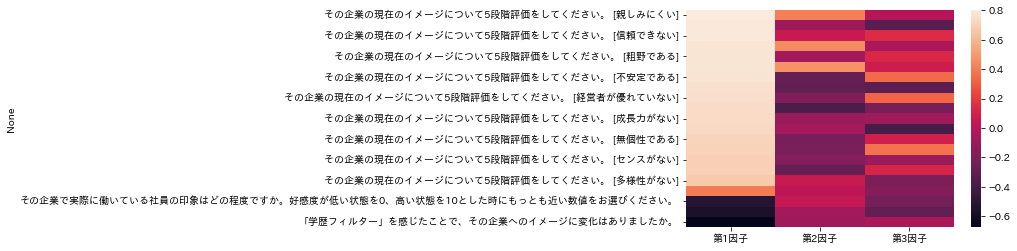

In [174]:
sns.heatmap(factor_df.sort_values(['第1因子', '第2因子', '第3因子'], ascending = False))

In [175]:
factor_df.sort_values(['第1因子', '第2因子', '第3因子'], ascending = False)

,第1因子,第2因子,第3因子
その企業の現在のイメージについて5段階評価をしてください。 [親しみにくい],0.803392,0.409700,-0.021105
その企業の現在のイメージについて5段階評価をしてください。 [活気がない],0.795470,-0.089874,-0.338150
その企業の現在のイメージについて5段階評価をしてください。 [信頼できない],0.791982,0.056544,0.141765
その企業の現在のイメージについて5段階評価をしてください。 [良心的でない],0.776927,0.447519,-0.054873
その企業の現在のイメージについて5段階評価をしてください。 [粗野である],0.776910,-0.069843,0.131663
その企業の現在のイメージについて5段階評価をしてください。 [つめたい],0.775300,0.470991,0.074110
その企業の現在のイメージについて5段階評価をしてください。 [不安定である],0.770615,-0.284112,0.343798
その企業の現在のイメージについて5段階評価をしてください。 [不活発である],0.757846,-0.299613,-0.317272
その企業の現在のイメージについて5段階評価をしてください。 [経営者が優れていない],0.755873,-0.195128,0.322628
その企業の現在のイメージについて5段階評価をしてください。 [地味である],0.744923,-0.381667,-0.220764
